In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy import stats
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from collections import Counter
import scanpy as sc
import anndata as an
import sys
import os
import gc

In [2]:
folder = 'data/'
file = 'tahoe_bulk_processed.h5ad'

In [3]:
adata = sc.read_h5ad(folder+file)
cellnumber_df = pd.read_csv('data/number_of_cells.tsv',sep='\t')
cellnumber_df['id'] = [row['plate']+'_'+row['cell_line']+'_'+row['MEASUREMENT'] for i,row in cellnumber_df.iterrows()]
cellnumbers = {row['id']:row['NUMBER_OF_CELLS'] for i,row in cellnumber_df.iterrows()}
cellnumbers1 = [cellnumbers[k] for k in adata.obs_names]
adata.obs['cell_number'] = cellnumbers1
readnumbers = {row['id']:row['NUMBER_OF_READS'] for i,row in cellnumber_df.iterrows()}
readnumbers1 = [readnumbers[k] for k in adata.obs_names]
adata.obs['read_number'] = readnumbers1
group_plates1 = ['plate1','plate2','plate3','plate4','plate5','plate6','plate14']
group_plates2 = ['plate7','plate8','plate9','plate10','plate11','plate12','plate13']
adata.obs['group_plate'] = [0 if p in group_plates1 else 1 for p in list(adata.obs['plate'])]
display(adata)

AnnData object with n_obs × n_vars = 61167 × 2000
    obs: 'plate', 'cellline', 'drug', 'drugconc', 'cell_number', 'read_number', 'group_plate'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

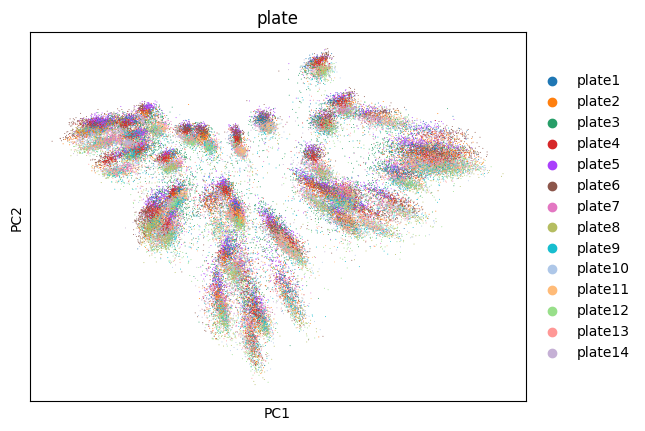

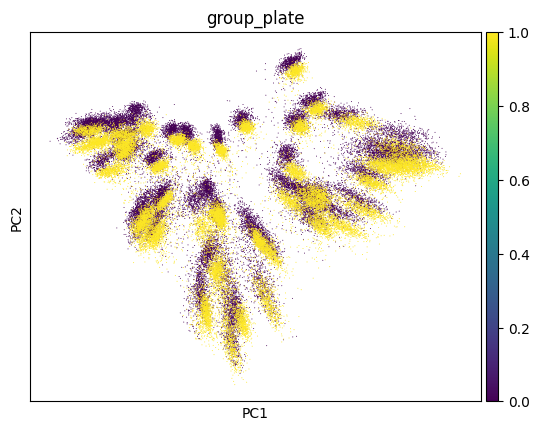

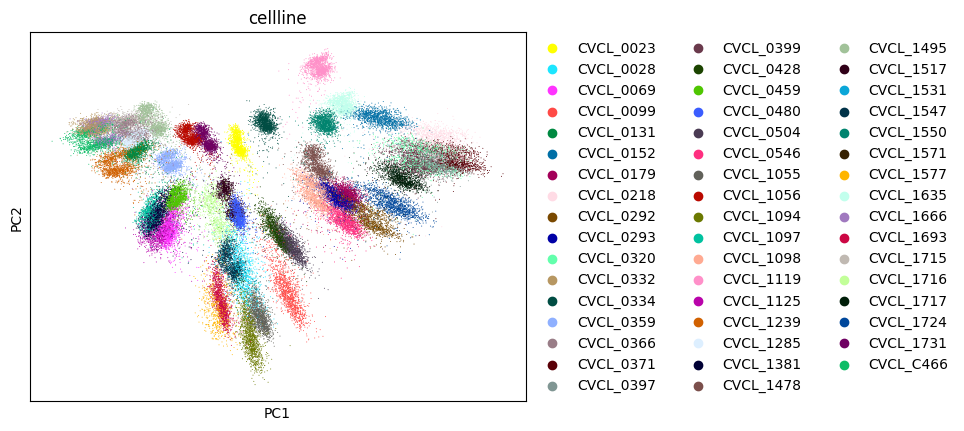

In [4]:
sc.pl.pca(adata,color='plate')
sc.pl.pca(adata,color='group_plate')
sc.pl.pca(adata,color='cellline')

/home/zinovyev/tahoe/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


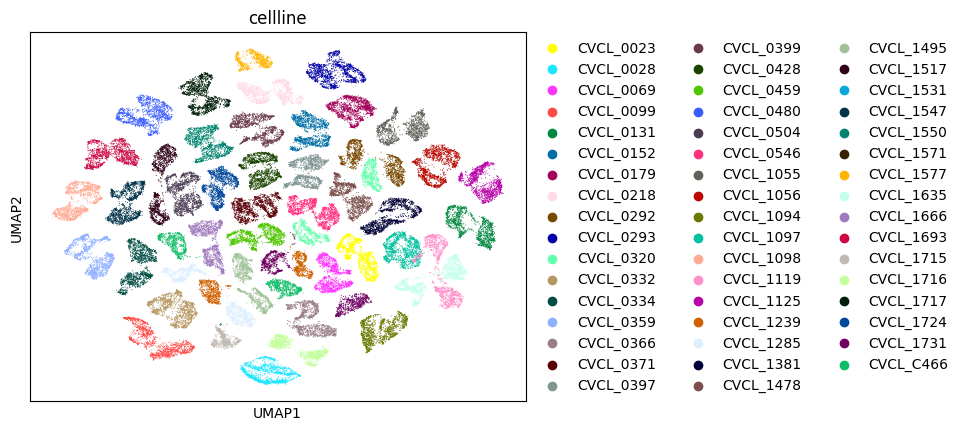

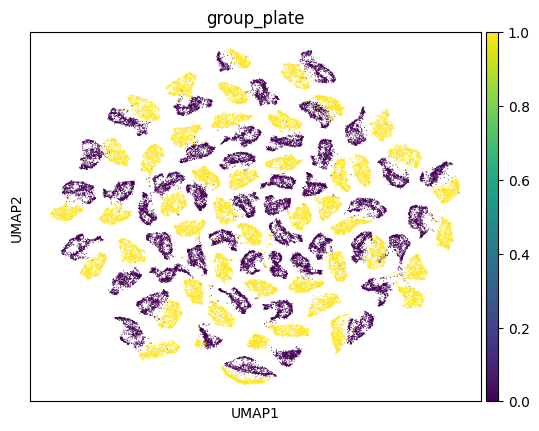

In [9]:
sc.pp.neighbors(adata,n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata,color='cellline')
sc.pl.umap(adata,color='group_plate')

/tmp/ipykernel_12631/1252662538.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cellline.obs['concentration'] = concs


AnnData object with n_obs × n_vars = 1307 × 2000
    obs: 'plate', 'cellline', 'drug', 'drugconc', 'cell_number', 'read_number', 'group_plate', 'concentration'
    uns: 'log1p', 'pca', 'plate_colors', 'cellline_colors'
    obsm: 'X_pca'
    varm: 'PCs'

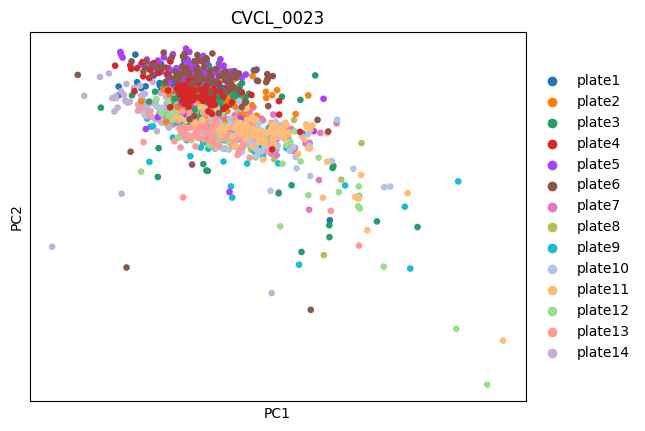

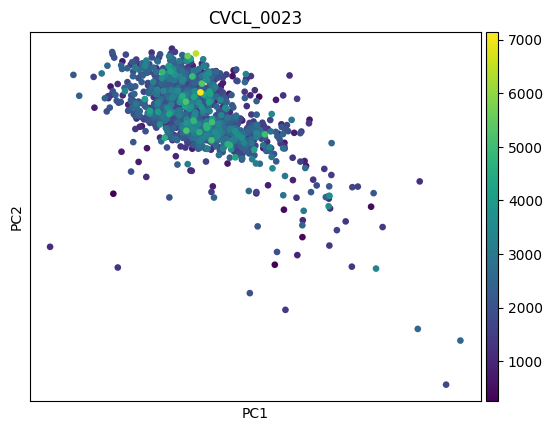

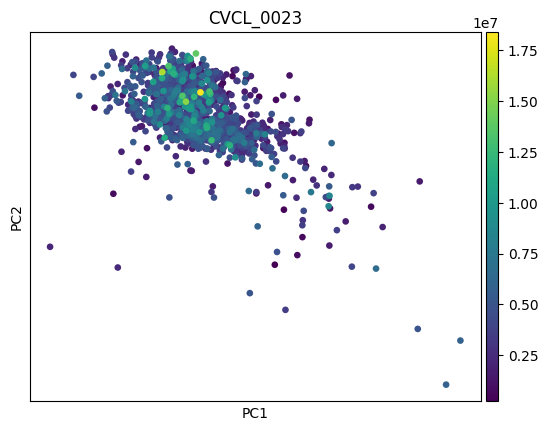

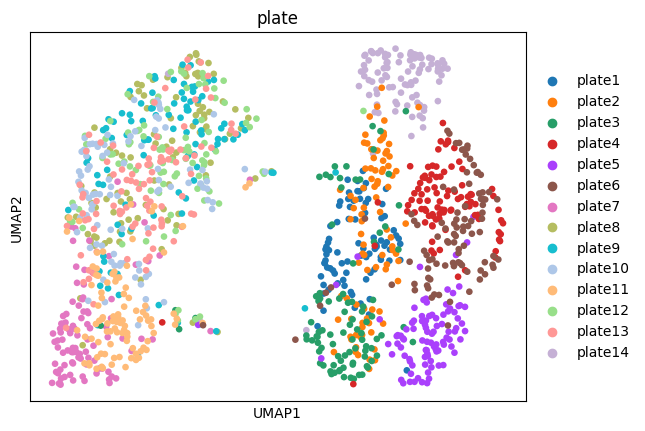

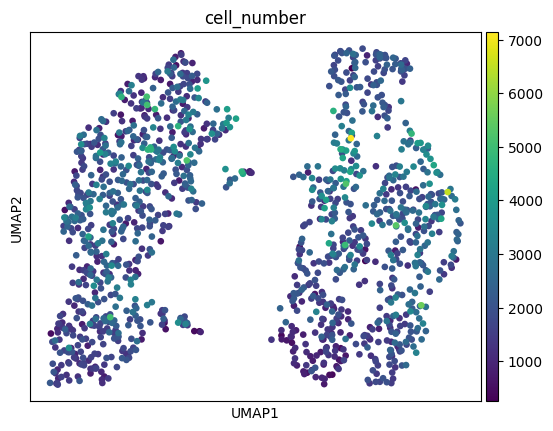

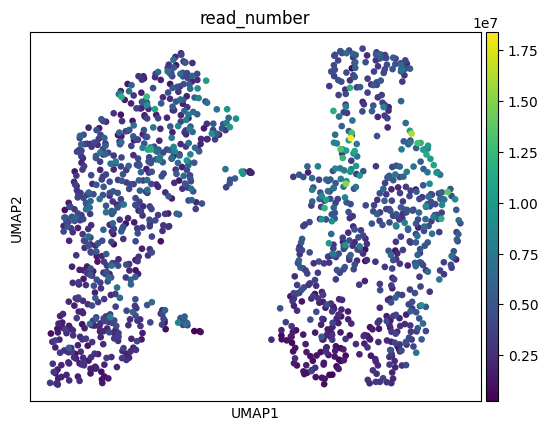

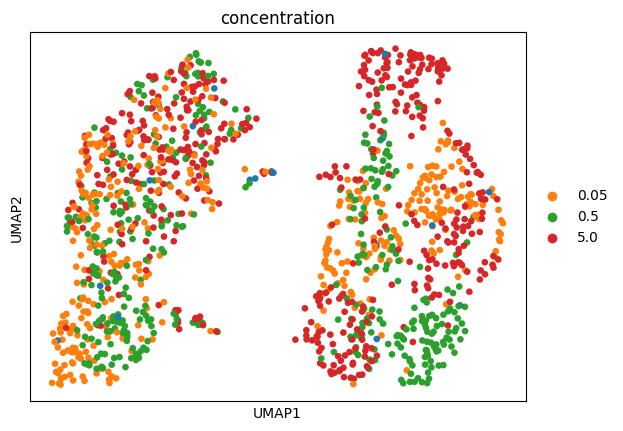

In [6]:
cellline = 'CVCL_0023'
#cellline = 'CVCL_0459'
#cellline = 'CVCL_0131'
#cellline = 'CVCL_1119'

adata_cellline = adata[adata.obs['cellline']==cellline,:]

dc = list(adata_cellline.obs_names)
#print(dc)
concs = []
for d in dc:
    parts = d.split('_')
    cellline = parts[1]+'_'+parts[2]
    conc = parts[5]
    concs.append(conc)

adata_cellline.obs['concentration'] = concs

display(adata_cellline)
sc.pl.pca(adata_cellline,color='plate',title=cellline)
sc.pl.pca(adata_cellline,color='cell_number',title=cellline)
sc.pl.pca(adata_cellline,color='read_number',title=cellline)
#sc.pl.pca(adata_cellline,color='drug',title=cellline)
sc.pp.neighbors(adata_cellline,n_neighbors=10,metric='correlation')
sc.tl.umap(adata_cellline)
#sc.pl.umap(adata_cellline,color='drug')
sc.pl.umap(adata_cellline,color='plate')
sc.pl.umap(adata_cellline,color='cell_number')
sc.pl.umap(adata_cellline,color='read_number')
sc.pl.umap(adata_cellline,color='concentration')

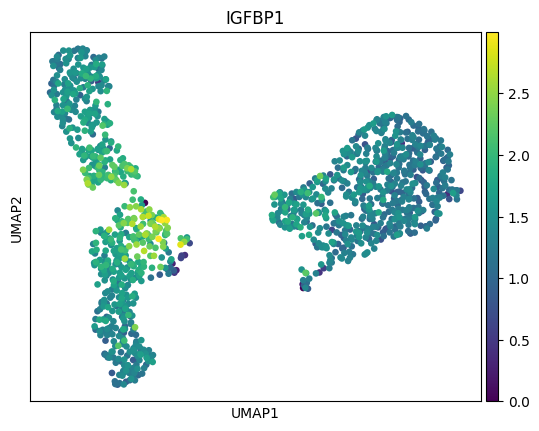

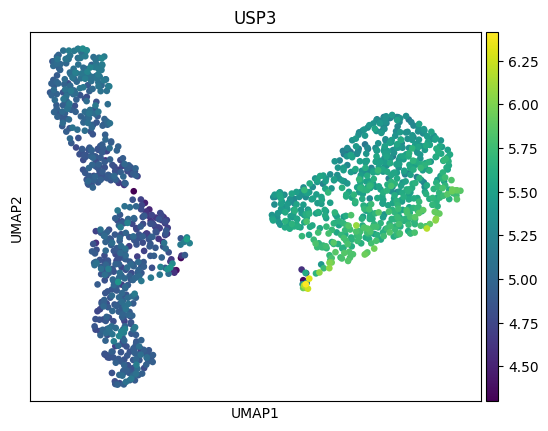

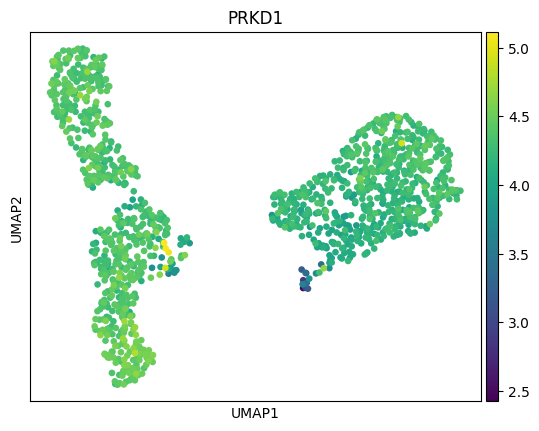

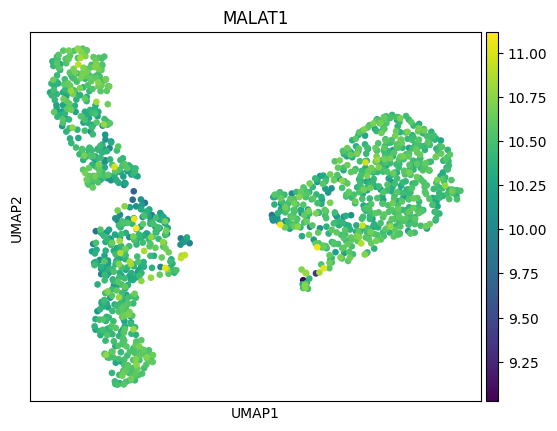

In [24]:
sc.pl.umap(adata_cellline,color='CDK1')
sc.pl.umap(adata_cellline,color='USP3')
sc.pl.umap(adata_cellline,color='PRKD1')
sc.pl.umap(adata_cellline,color='MALAT1')

In [25]:
adata.obs['group_plate'] = ['0' if p in group_plates1 else '1' for p in list(adata.obs['plate'])]
print(adata.obs['group_plate'])
sc.tl.rank_genes_groups(adata, groupby="group_plate", method="wilcoxon")

plate4_CVCL_0152_Temsirolimus__0.05                     0
plate4_CVCL_0152_Lenalidomide (hemihydrate)__0.05       0
plate4_CVCL_0152_Demeclocycline__0.05                   0
plate4_CVCL_0152_(R)-Verapamil (hydrochloride)__0.05    0
plate4_CVCL_0152_Neratinib (maleate)__0.05              0
                                                       ..
plate12_CVCL_1119_Idoxuridine__5.0                      1
plate12_CVCL_1119_Methotrexate__5.0                     1
plate12_CVCL_1119_Auranofin__5.0                        1
plate12_CVCL_1119_Nafamostat (mesylate)__5.0            1
plate12_CVCL_1119_Cabozantinib (S-malate)__5.0          1
Name: group_plate, Length: 61167, dtype: object


In [37]:
df_ranks = sc.get.rank_genes_groups_df(adata, group="0")
display(df_ranks)
#sns.lineplot(df_ranks,x='names',y='scores')
genesplus = [row['names'] for i,row in df_ranks.iterrows() if row['scores']<-75]
for g in genesplus:
    print(g)

,names,scores,logfoldchanges,pvals,pvals_adj
0,RPL31P46,159.069748,1.363454,0.0,0.0
1,GARIN1A,153.991516,1.359975,0.0,0.0
2,PPIEL-1,141.362183,1.388445,0.0,0.0
3,ENSG00000256448,139.833130,1.251201,0.0,0.0
4,GARIN1B,139.223160,2.396099,0.0,0.0
...,...,...,...,...,...
19995,BORA,-137.171326,-0.897225,0.0,0.0
19996,TTK,-142.366714,-1.203638,0.0,0.0
19997,NUP58,-142.625870,-0.742937,0.0,0.0
19998,USP3,-145.462051,-0.799282,0.0,0.0


RPL31P46
GARIN1A
PPIEL-1
ENSG00000256448
GARIN1B
LINC02803
AVEN
ENSG00000290241
IL12RB2
PPIEL
ENSG00000229321
ANKDD1B
USP50
TRIM72
ENSG00000240963
GABRR2
ENSG00000234500
PILRA
ENSG00000286677
AVIL
PNPLA1
SLC22A1
ENSG00000286782
ENSG00000260392
ANKAR
SEMA4A
AADACL2-AS1
PLAC8L1
IMPA1P1
IDI2-AS1
FLACC1
C3orf20
ENSG00000254459
LINC02133
ENSG00000225450
ENSG00000240710
XG
SELPLG
ENSG00000279608
CDKL4
NEK11
INTS6
ENSG00000257894
ENSG00000258378
C19orf38
PLSCR2
CFAP70
MYOCOS
SLC6A13
MZF1-AS1
SLC2A9
ENSG00000249319
SPTBN5
TUBA8
LINC01191
ENSG00000249476
LINC01004
LRRC43
MSANTD1
ENSG00000290762
ENSG00000286952
C5AR1
ALDH8A1
LINC02936
ENSG00000251143
TRPC7-AS1
LINC01588
ENSG00000287721
FGF18
WNT2B
PXDNL
EPC2
LINC02236
ENSG00000286239
ENSG00000289997
ENSG00000279320
ENSG00000285404
NIBAN3
OIT3
KRT20
QRICH2
TRPV1
ENSG00000235419
ZSCAN5A
ZDHHC11
ORAI2
FAM151B
ENSG00000229195
FNDC7
ITGA9
STYXL1
ENSG00000283573
KANSL1L-AS1
SPINK13
ENSG00000255202
MPP4
SLC23A3
EHBP1-AS1
TECPR2
HCG17
MMP25
LRRD1
LINC00

<Axes: xlabel='PLATE_GROUP', ylabel='TTK'>

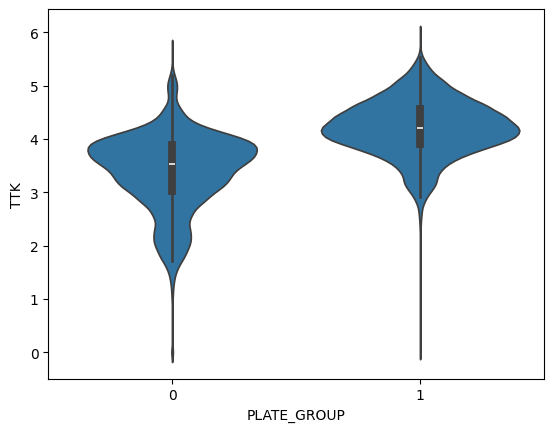

In [36]:
import seaborn as sns
gene = 'TTK'
df = pd.DataFrame(data={gene:list(adata[:,gene].X.ravel()),'PLATE_GROUP':list(adata.obs['group_plate'])})
sns.violinplot(df,x='PLATE_GROUP',y=gene)

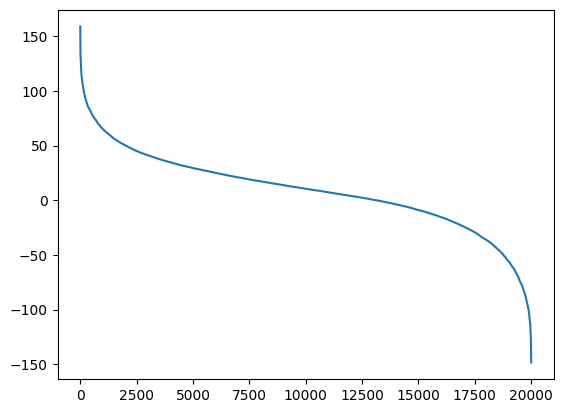

In [30]:
plt.plot(df_ranks['scores'])

,names,scores,logfoldchanges,pvals,pvals_adj
0,RPL31P46,159.069748,1.363454,0.0,0.0
1,GARIN1A,153.991516,1.359975,0.0,0.0
2,PPIEL-1,141.362183,1.388445,0.0,0.0
3,ENSG00000256448,139.833130,1.251201,0.0,0.0
4,GARIN1B,139.223160,2.396099,0.0,0.0
...,...,...,...,...,...
19995,BORA,-137.171326,-0.897225,0.0,0.0
19996,TTK,-142.366714,-1.203638,0.0,0.0
19997,NUP58,-142.625870,-0.742937,0.0,0.0
19998,USP3,-145.462051,-0.799282,0.0,0.0
